Authors: Kiril Andrukh, *162069* & Uladzislau Lukashevich, *155671*

Link to the source code: https://github.com/AndrukhKiril/EvolutionaryComputation

# Description of a problem

>We are given three columns of integers with a row for each node. 
>
>The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized.
>
>The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

# Imports and implementations of basic functions

In [1]:
import pandas as pd

import numpy as np
np.random.seed(1337)


dataset_A = pd.read_csv('../TSPA.csv', sep=';', names=['x', 'y', 'cost'])
dataset_B = pd.read_csv('../TSPB.csv', sep=';', names=['x', 'y', 'cost'])

dataset_A.shape, dataset_B.shape

((200, 3), (200, 3))

In [2]:
node1, node2 = dataset_B.iloc[177], dataset_B.iloc[43]

print(f'{node1}\n\n{node2}')

x       1450
y        398
cost      52
Name: 177, dtype: int64

x       1654
y       1486
cost     638
Name: 43, dtype: int64


In [3]:
def euclidean_distance(node1, node2):
    return np.int32(((node1['x'] - node2['x']) ** 2 + (node1['y'] - node2['y']) ** 2) ** 0.5 + 0.5)

In [4]:
print(f'distance between node1 and node2 = {euclidean_distance(node1, node2)}')

distance between node1 and node2 = 1107


In [5]:
def nodes_cost(node1, node2):
    return node1['cost'] + node2['cost']

In [6]:
print(f'objective function of node1 and node2 = {euclidean_distance(node1, node2) + nodes_cost(node1, node2)}')

objective function of node1 and node2 = 1797


In [7]:
def calculate_function_cost(dataset):
    cost = 0

    x = dataset['x'].to_numpy()
    y = dataset['y'].to_numpy()

    for i in range(len(x) - 1):
        cost += euclidean_distance({'x': x[i], 'y': y[i]}, {'x': x[i+1], 'y': y[i+1]})

    cost += euclidean_distance({'x': x[-1], 'y': y[-1]}, {'x': x[0], 'y': y[0]})

    cost += dataset['cost'].sum()    

    return int(cost)

In [8]:
def calculate_distance_matrix(dataset):
    num_nodes = len(dataset)

    distance_matrix = np.zeros((num_nodes, num_nodes), dtype=np.float64)

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                node1 = dataset.iloc[i]
                node2 = dataset.iloc[j]
                distance = euclidean_distance(node1, node2)
                
                if np.isinf(distance) or np.isnan(distance):
                    raise ValueError(f"Invalid distance encountered between nodes {i} and {j}")

                cost = nodes_cost(node1, node2)
                distance_matrix[i, j] = distance + cost

    return distance_matrix

In [9]:
distance_matrices = []

for dataset in [dataset_A, dataset_B]:
    distance_matrices.append(calculate_distance_matrix(dataset))

In [10]:
print(f'objective function of node1 and node2 = {distance_matrices[1][177, 43]}')

objective function of node1 and node2 = 1797.0


In [11]:
import matplotlib.pyplot as plt

import seaborn as sns

def plot(dataset, with_order=False):
    max_x = dataset['x'].max()
    max_y = dataset['y'].max()

    aspect_ratio = int(max_x / max_y)

    if max_x > max_y:
        height = 6.0 
        width = height * aspect_ratio
    else:
        width = 6.0
        height = width * aspect_ratio

    sns.set_theme(rc={'figure.figsize': (width, height)})

    sns.scatterplot(
        data=dataset,
        x='x',
        y='y',
        size='cost',
        legend=False
    )

    if with_order:
        x = dataset['x'].to_numpy()
        y = dataset['y'].to_numpy()

        for i in range(len(x) - 1):
            plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], color='b', linestyle='-')

        plt.plot([x[-1], x[0]], [y[-1], y[0]], color='b', linestyle='-')

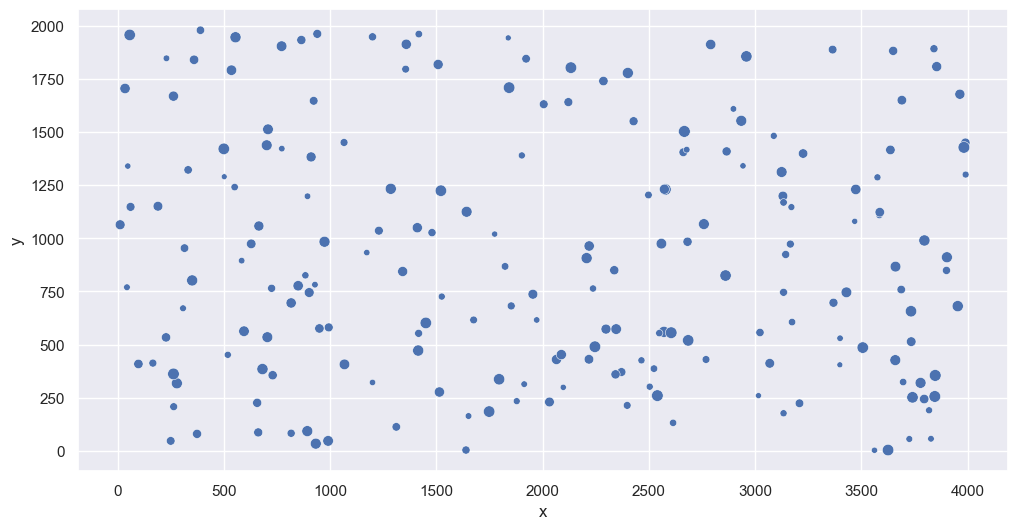

In [12]:
plot(dataset_A)
plt.show()

In [13]:
plot(dataset_B)
plt.show()

# Implementations of methods for TSP solving.

## Random solution

### Pseudocode

> <div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
> &nbsp;&nbsp;&nbsp;&nbsp; Randomly select half of the dataset without replacement. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Return: the selected elements as the solution. <br>
> </div>

### Code

In [14]:
def generate_random_solution(dataset):
    size = int(len(dataset) * 0.5 + 0.5)    

    return dataset.sample(n=size, replace=False)

In [15]:
random_solution_A = generate_random_solution(dataset_A)
random_solution_A

x     y  cost
29    990    47  1499
117  1199  1948   611
69    359  1840  1033
174  3797   990  1716
97   2465   426   310
..    ...   ...   ...
33   2578  1230  1855
183  1838  1943    43
175  3828    57   178
75   2614   132   360
171  3726    56   237

[100 rows x 3 columns]

In [16]:
random_solution_B = generate_random_solution(dataset_B)
random_solution_B

x     y  cost
61   1736   127   313
47   3907  1503   174
98   1116  1294   697
154  3958  1389   782
91   1856   126   523
..    ...   ...   ...
84   2347  1997   874
181  3209  1224   935
8    1946   680   119
76   3688   376   766
16    119   890   585

[100 rows x 3 columns]

In [17]:
for number, dataset in enumerate([dataset_A, dataset_B]):
    rating = []

    for _ in range(200):
        random_solution = generate_random_solution(dataset)

        solution = list(random_solution.index)

        rating.append((solution, calculate_function_cost(random_solution)))

    best_solution = sorted(rating, key=lambda x: x[1])[0]

    print(best_solution[0])
    print(f'Objective function = {best_solution[1]}')
    print('################################\n')

    print(f"Min: {sorted(rating, key=lambda x: x[1])[0][1]}")
    
    average = sum([obj_function for solution, obj_function in rating])/len(rating)

    print(f'Average: {average}')
    print(f"Max: {sorted(rating, key=lambda x: x[1])[-1][1]}")

    plot(dataset.loc[best_solution[0]], with_order=True)
    plt.savefig(f'Plots/random_solution_{['A', 'B'][number]}.png')
    plt.show()

[166, 136, 116, 30, 71, 62, 24, 111, 123, 69, 154, 160, 189, 149, 80, 21, 103, 182, 82, 178, 55, 29, 47, 28, 190, 142, 140, 48, 41, 10, 92, 106, 173, 81, 155, 16, 64, 130, 94, 11, 126, 33, 54, 148, 38, 14, 42, 194, 191, 159, 68, 20, 53, 197, 34, 74, 115, 63, 139, 107, 151, 183, 112, 46, 23, 120, 104, 192, 1, 88, 163, 72, 172, 105, 83, 185, 144, 124, 84, 113, 196, 188, 175, 138, 8, 91, 79, 167, 150, 171, 59, 77, 181, 7, 97, 184, 22, 143, 134, 122]
Objective function = 243393
################################

Min: 243393
Average: 265009.32
Max: 296391


[137, 66, 164, 112, 122, 155, 154, 71, 191, 77, 141, 145, 118, 8, 57, 127, 68, 10, 84, 199, 75, 29, 108, 128, 34, 179, 114, 138, 168, 176, 131, 98, 156, 25, 63, 30, 36, 117, 7, 134, 126, 106, 41, 32, 19, 15, 142, 28, 86, 189, 0, 42, 181, 6, 187, 61, 109, 174, 130, 82, 149, 129, 139, 31, 69, 26, 53, 183, 186, 103, 14, 162, 143, 167, 18, 197, 160, 144, 44, 5, 35, 169, 92, 192, 9, 99, 39, 182, 67, 171, 133, 116, 177, 93, 105, 120, 150, 74, 80, 3]
Objective function = 190669
################################

Min: 190669
Average: 212375.76
Max: 241913


## Nearest neighbor considering adding the node only at the end of the current path

### Pseudocode

> <div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
> &nbsp;&nbsp;&nbsp;&nbsp; Create a solution `X` containing the starting node. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Mark the starting node as visited. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Calculate the distance matrix between nodes.<br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; <b>repeat</b> <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Determine the unvisited neighbor closest to the last node in `X`. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Add the nearest neighbor to `X`. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Mark the added neighbor as visited. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; <b>until</b> the desired solution size is reached. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Return: The solution `X`.
> </div>

### Code

In [18]:
def generate_nearest_neighbor_end(dataset, distance_matrix, starting_node):
    size = int(len(dataset) * 0.5 + 0.5)
    num_nodes = len(dataset)

    distance_matrix = distance_matrix.copy()
    
    remaining_mask = np.ones(num_nodes, dtype=bool)
    solution = [starting_node]
    remaining_mask[starting_node] = False

    while len(solution) < size:
        last_node = solution[-1]
        
        distances_to_last_node = distance_matrix[last_node]
        distances_to_last_node[~remaining_mask] = np.inf 
        
        nearest_node = np.argmin(distances_to_last_node)
        solution.append(nearest_node)
        remaining_mask[nearest_node] = False
    
    return dataset.loc[solution]

[124, 94, 63, 53, 180, 154, 135, 123, 65, 116, 59, 115, 139, 193, 41, 42, 160, 34, 22, 18, 108, 69, 159, 181, 184, 177, 54, 30, 48, 43, 151, 176, 80, 79, 133, 162, 51, 137, 183, 143, 0, 117, 46, 68, 93, 140, 36, 163, 199, 146, 195, 103, 5, 96, 118, 149, 131, 112, 4, 84, 35, 10, 190, 127, 70, 101, 97, 1, 152, 120, 78, 145, 185, 40, 165, 90, 81, 113, 175, 171, 16, 31, 44, 92, 57, 106, 49, 144, 62, 14, 178, 52, 55, 129, 2, 75, 86, 26, 100, 121]
Objective function = 83182
################################

Min: 83182
Average: 85108.51
Max: 89433


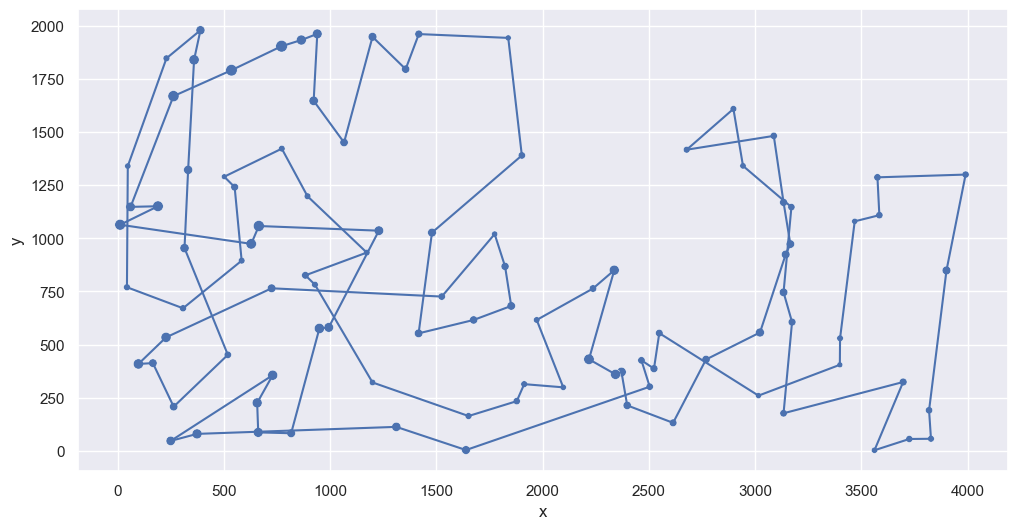

[16, 1, 117, 31, 54, 193, 190, 80, 175, 5, 177, 36, 61, 141, 77, 153, 163, 176, 113, 166, 86, 185, 179, 94, 47, 148, 20, 60, 28, 140, 183, 152, 18, 62, 124, 106, 143, 0, 29, 109, 35, 33, 138, 11, 168, 169, 188, 70, 3, 145, 15, 155, 189, 34, 55, 95, 130, 99, 22, 66, 154, 57, 172, 194, 103, 127, 89, 137, 114, 165, 187, 146, 81, 111, 8, 104, 21, 82, 144, 160, 139, 182, 25, 121, 90, 122, 135, 63, 40, 107, 100, 133, 10, 147, 6, 134, 51, 98, 118, 74]
Objective function = 52319
################################

Min: 52319
Average: 54390.43
Max: 59030


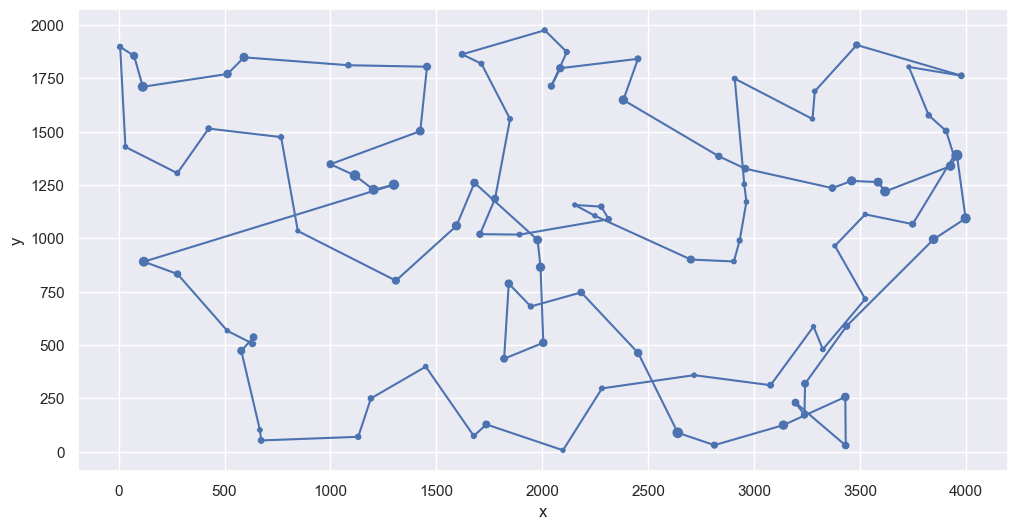

In [19]:
for distance_matrix, dataset in enumerate([dataset_A, dataset_B]):
    rating = []

    for idx in range(200):
        nn_end_solution = generate_nearest_neighbor_end(dataset, distance_matrices[distance_matrix], idx)

        solution = list(nn_end_solution.index)

        rating.append((solution, calculate_function_cost(nn_end_solution)))

    best_solution = sorted(rating, key=lambda x: x[1])[0]

    print(best_solution[0])
    print(f'Objective function = {best_solution[1]}')
    print('################################\n')

    print(f"Min: {sorted(rating, key=lambda x: x[1])[0][1]}")
    
    average = sum([obj_function for solution, obj_function in rating])/len(rating)

    print(f'Average: {average}')
    print(f"Max: {sorted(rating, key=lambda x: x[1])[-1][1]}")

    plot(dataset.loc[best_solution[0]], with_order=True)
    plt.savefig(f'Plots/nn_end_{['A', 'B'][distance_matrix]}.png')
    plt.show()

## Nearest neighbor considering adding the node at all possible position, i.e. at the end, at the beginning, or at any place inside the current path

### Pseudocode

> <div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
> &nbsp;&nbsp;&nbsp;&nbsp; Create a solution `X` containing the starting node. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Mark the starting node as visited. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Calculate the distance matrix between nodes.<br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; <b>repeat</b> <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; For each unvisited neighbor, determine the insertion position in `X` that minimizes the total cost. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Add the neighbor to `X` at the best insertion position. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Mark the added neighbor as visited. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; <b>until</b> the desired solution size is reached. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Return: The solution `X`.
> </div>

### Code

In [20]:
def generate_nearest_neighbor_best_position(dataset, distance_matrix, starting_node):
    size = int(len(dataset) * 0.5 + 0.5)
    num_nodes = len(dataset)

    distance_matrix = distance_matrix.copy()

    solution = [starting_node]
    
    remaining_nodes = set(range(num_nodes))
    remaining_nodes.remove(starting_node)

    while len(solution) < size:
        best_insertion_cost = float('inf')
        best_insertion = None

        for node_idx in remaining_nodes:
            node_cost = dataset.loc[node_idx, 'cost']
            for i in range(len(solution) + 1):
                if i == 0:
                    prev_node = solution[-1]
                else:
                    prev_node = solution[i - 1]

                if i == len(solution):
                    next_node = solution[0]
                else:
                    next_node = solution[i]

                insert_cost = (
                    distance_matrix[prev_node, node_idx] + 
                    distance_matrix[node_idx, next_node] - 
                    distance_matrix[prev_node, next_node]
                )

                total_cost = insert_cost + node_cost

                if total_cost < best_insertion_cost:
                    best_insertion_cost = total_cost
                    best_insertion = (node_idx, i)
        
        solution.insert(best_insertion[1], best_insertion[0])
        remaining_nodes.remove(best_insertion[0])

    return dataset.loc[solution]


[164, 27, 90, 165, 40, 185, 81, 196, 179, 145, 78, 31, 113, 175, 171, 16, 25, 44, 120, 75, 101, 1, 97, 26, 100, 86, 53, 154, 135, 70, 127, 123, 112, 4, 84, 35, 149, 65, 116, 43, 42, 184, 190, 10, 177, 54, 160, 34, 181, 146, 22, 18, 108, 159, 193, 41, 139, 68, 46, 115, 118, 59, 162, 151, 133, 180, 63, 79, 80, 176, 51, 0, 117, 143, 183, 89, 186, 23, 137, 15, 148, 124, 94, 152, 2, 129, 92, 57, 55, 52, 106, 178, 49, 102, 9, 62, 144, 14, 21, 7]
Objective function = 71329
################################

Min: 71329
Average: 72183.035
Max: 73282


[149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 113, 176, 103, 114, 137, 127, 89, 163, 153, 187, 141, 91, 61, 36, 78, 175, 80, 190, 136, 73, 193, 117, 31, 54, 198, 156, 1, 27, 38, 135, 63, 40, 107, 133, 122, 90, 147, 51, 131, 121, 25, 5, 177, 21, 82, 77, 81, 111, 8, 104, 144, 160, 33, 138, 11, 139, 145, 15, 155, 3, 70, 188, 6, 169, 132, 13, 195, 168, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 4]
Objective function = 46193
################################

Min: 46193
Average: 47038.35
Max: 48330


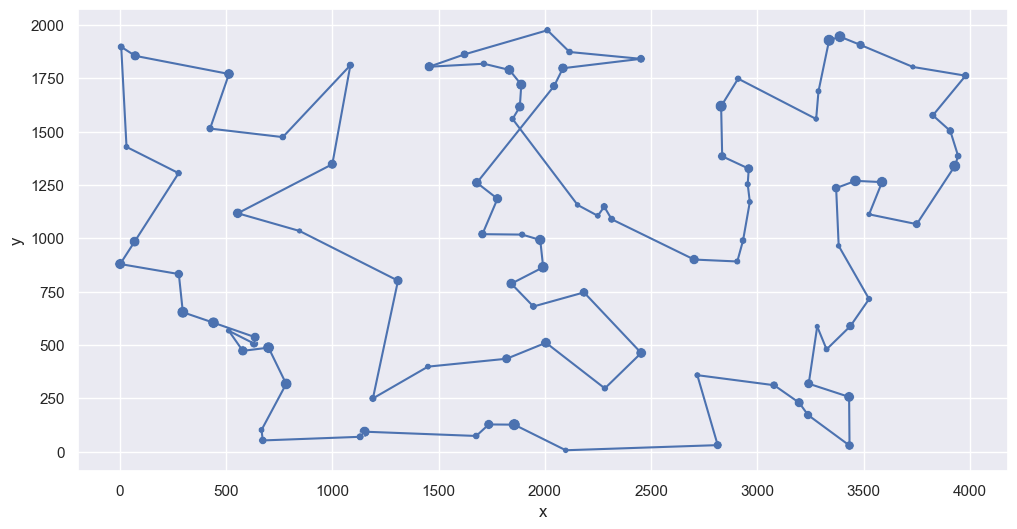

In [21]:
for distance_matrix, dataset in enumerate([dataset_A, dataset_B]):
    rating = []

    for idx in range(200):
        nn_best_pos_solution = generate_nearest_neighbor_best_position(dataset, distance_matrices[distance_matrix], idx)

        solution = list(nn_best_pos_solution.index)

        rating.append((solution, calculate_function_cost(nn_best_pos_solution)))

    best_solution = sorted(rating, key=lambda x: x[1])[0]

    print(best_solution[0])
    print(f'Objective function = {best_solution[1]}')
    print('################################\n')

    print(f"Min: {sorted(rating, key=lambda x: x[1])[0][1]}")
    
    average = sum([obj_function for solution, obj_function in rating])/len(rating)

    print(f'Average: {average}')
    print(f"Max: {sorted(rating, key=lambda x: x[1])[-1][1]}")

    plot(dataset.loc[best_solution[0]], with_order=True)
    plt.savefig(f'Plots/nn_best_position_{['A', 'B'][distance_matrix]}.png')
    plt.show()

## Greedy cycle

### Pseudocode

> <div style="background-color:rgba(0, 0, 0, 0.0470588); padding:10px 0;font-family:monospace;">
> &nbsp;&nbsp;&nbsp;&nbsp; Create a solution `X` containing the starting node. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Mark the starting node as visited. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Calculate the distance matrix between nodes.<br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; <b>repeat</b> <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Determine the node with best cost not yet added into `X`. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Add the node to `X`. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp; Mark the added neighbor as visited. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; <b>until</b> the desired solution size is reached. <br>
>
> &nbsp;&nbsp;&nbsp;&nbsp; Return: The solution `X`.
> </div>

### Code

In [22]:
def generate_greedy_cycle(dataset, distance_matrix, starting_node):
    size = int(len(dataset) * 0.5 + 0.5)
    num_nodes = len(dataset)

    distance_matrix = distance_matrix.copy()

    remaining_nodes = set(range(num_nodes))
    remaining_nodes.remove(starting_node)
    solution = [starting_node]

    nearest_node = np.argmin(distance_matrix[starting_node, list(remaining_nodes)])
    nearest_node_idx = list(remaining_nodes)[nearest_node]
    solution.append(nearest_node_idx)
    remaining_nodes.remove(nearest_node_idx)

    while len(solution) < size:
        best_insertion_cost = float('inf')
        best_insertion = None

        for node_idx in remaining_nodes:
            for i in range(len(solution)):
                next_i = (i + 1) % len(solution)

                current_cost = (
                    distance_matrix[solution[i], node_idx] +
                    distance_matrix[node_idx, solution[next_i]] -
                    distance_matrix[solution[i], solution[next_i]]
                )
                
                if current_cost < best_insertion_cost:
                    best_insertion_cost = current_cost
                    best_insertion = (node_idx, i)
        
        solution.insert(best_insertion[1] + 1, best_insertion[0])
        remaining_nodes.remove(best_insertion[0])
    
    return dataset.loc[solution]

In [23]:
for distance_matrix, dataset in enumerate([dataset_A, dataset_B]):
    rating = []

    for idx in range(200):
        greedy_cycle_solution = generate_greedy_cycle(dataset, distance_matrices[distance_matrix], idx)

        solution = list(greedy_cycle_solution.index)

        rating.append((solution, calculate_function_cost(greedy_cycle_solution)))

    best_solution = sorted(rating, key=lambda x: x[1])[0]

    print(best_solution[0])
    print(f'Objective function = {best_solution[1]}')
    print('################################\n')

    print(f"Min: {sorted(rating, key=lambda x: x[1])[0][1]}")
    
    average = sum([obj_function for solution, obj_function in rating])/len(rating)

    print(f'Average: {average}')
    print(f"Max: {sorted(rating, key=lambda x: x[1])[-1][1]}")

    plot(dataset.loc[best_solution[0]], with_order=True)
    plt.savefig(f'Plots/greedy_cycle_{['A', 'B'][distance_matrix]}.png')
    plt.show()

[0, 117, 143, 183, 89, 186, 23, 137, 176, 80, 79, 94, 63, 152, 97, 1, 2, 129, 92, 57, 55, 52, 49, 102, 148, 9, 62, 144, 14, 178, 106, 185, 165, 21, 7, 164, 27, 90, 40, 81, 196, 179, 145, 78, 31, 113, 175, 171, 16, 25, 44, 120, 75, 101, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 149, 131, 65, 116, 43, 184, 35, 84, 112, 4, 190, 10, 177, 54, 48, 160, 34, 181, 42, 115, 41, 193, 159, 146, 22, 18, 108, 139, 68, 46]
Objective function = 71263
################################

Min: 71263
Average: 72071.915
Max: 73154


[4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 113, 176, 103, 114, 137, 127, 89, 163, 187, 153, 81, 77, 141, 91, 61, 36, 175, 78, 45, 5, 177, 21, 82, 111, 8, 104, 138, 11, 139, 182, 25, 136, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 121, 51, 90, 131, 135, 63, 40, 107, 122, 133, 10, 147, 6, 188, 169, 132, 70, 3, 155, 15, 145, 13, 195, 168, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140]
Objective function = 45312
################################

Min: 45312
Average: 46903.73
Max: 48623


# Conclusion

> Comparing all the methods together, the best performance was reached with Greedy cycle, with following best objective function values: 
>
> Dataset A: 71263; Dataset B: 45312. 
>
> Nearest Neighbor with best possible position choice on the current path was the longest algorithm to execute. The reason to this is due to Nearest Neighbor with best possible position having $O(n^2 * k)$ complexity, where `n` is the number of remaining nodes and `k` is the number of visited nodes. Greedy cycle on the other hand has $O(n^2)$ complexity, while having better performance.
>
> Obviously, the random solution worked the worst, and the less sophisticated Nearest Neighbor with end node on the current path was the second least optimized method.